In [1]:
# using Distributed
# using SharedArrays
# addprocs(11);

In [2]:
@everywhere include("inverse_prob.jl")

In [35]:
@everywhere begin
    file = matopen("marmousi_model/marmousi_vp10.mat")
    c0 = read(file, "marmousi_vp20") * 1e3
    close(file)
end

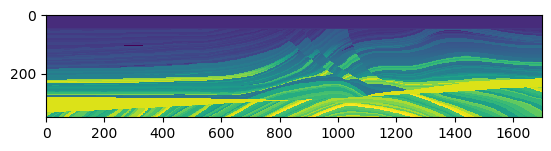

PyObject <matplotlib.image.AxesImage object at 0x7f62568ccf28>

In [36]:
imshow(c0)

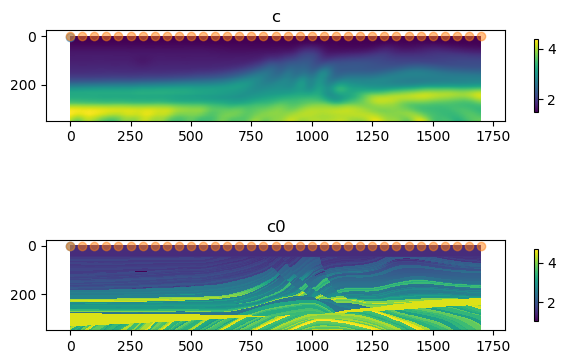

In [44]:
@eval @everywhere begin
    Nx, Ny = size(c0)
    h = 10

    Fs = 400;
    dt = 1/Fs
    Nt = 1001;
    t = range(0, length=Nt, step=dt)

    source = source_ricker(5, 0.2, t)
    source_position = zeros(1,2)
    for i = 1:1
        source_position[i,:] = [3,100*(i-1)+1]
    end
    source = repeat(source, 1, 1)

    receiver_position = zeros(35,2)
    for i = 1:35
        receiver_position[i,:] = [1,(i-1)*50+1]
    end

    rho0 = ones(Nx,Ny)
    c = imfilter(c0, Kernel.gaussian(20));
    rho = ones(Nx,Ny)
    pml_len = 20
    pml_coef = 100

end

figure
subplot(211)
imshow(c); colorbar(shrink=0.3); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(212)
imshow(c0); colorbar(shrink=0.3); title("c0")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)

tight_layout()

In [45]:
@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

370.682104 seconds (2.25 M allocations: 115.800 MiB, 0.02% gc time)
460.521523 seconds (33.77 k allocations: 906.711 KiB)


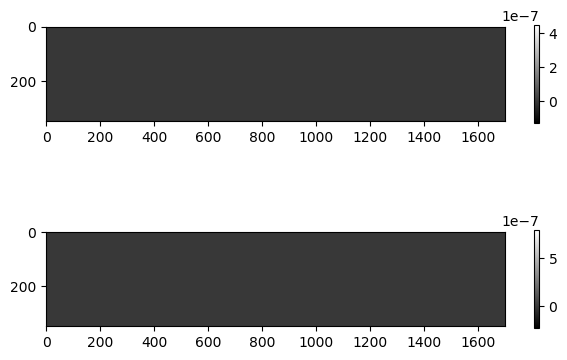

In [50]:
figure;
subplot(211); imshow(u[:,:,300,1],cmap=ColorMap("gray")); colorbar(shrink=0.4);
subplot(212);imshow(u0[:,:,500,1],cmap=ColorMap("gray")); colorbar(shrink=0.4);
tight_layout()

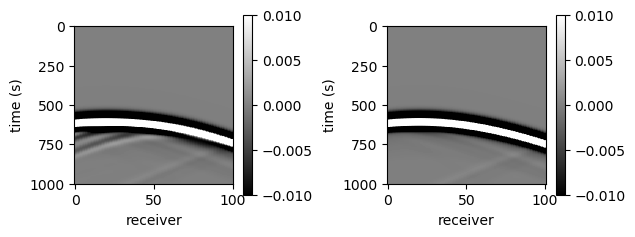

In [7]:
figure;
r_axis = 0:21
subplot(121); imshow(data[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [8]:
M = cost_matrix_1d(t, t; p=2)
@time adj_s, dd = adj_source_sinkhorn_parallel(data, data0, M; reg=5e-3, reg_m=1e2, iterMax=100, verbose=false);

 27.661696 seconds (4.43 M allocations: 229.014 MiB, 0.48% gc time)


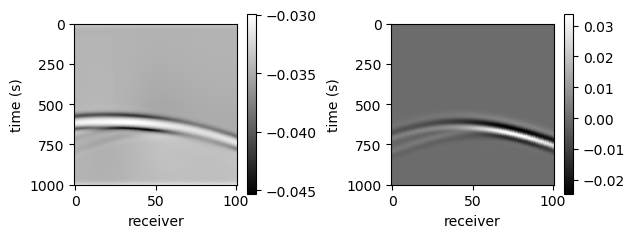

In [9]:
figure;
r_axis = 0:21
subplot(121); imshow(adj_s[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4);
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,3]-data[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4);
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [10]:
@time gg, dd = grad_sinkhorn_parallel(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100, reg=1e-3, reg_m=1e2, iterMax=100, verbose=false);

 38.098783 seconds (5.22 M allocations: 8.636 GiB, 2.35% gc time)


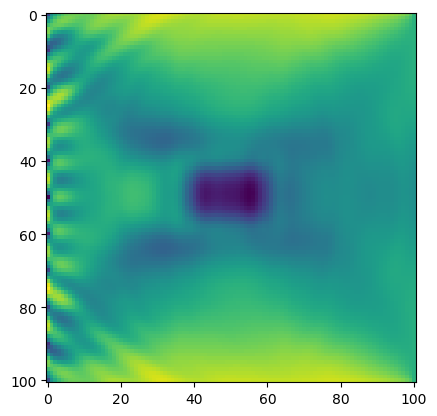

PyObject <matplotlib.image.AxesImage object at 0x7f2aef26e710>

In [11]:
imshow(gg)

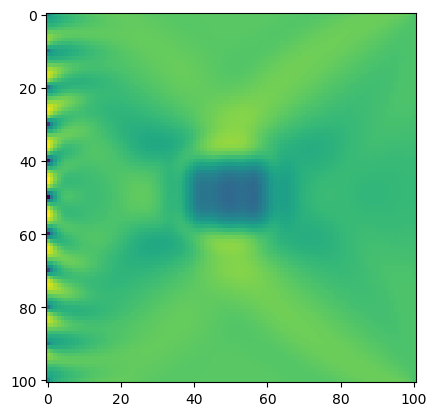

 27.194633 seconds (10.19 M allocations: 123.951 GiB, 19.24% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7f2aef2dd748>

In [12]:
@time ggl = grad_l2(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
imshow(ggl)

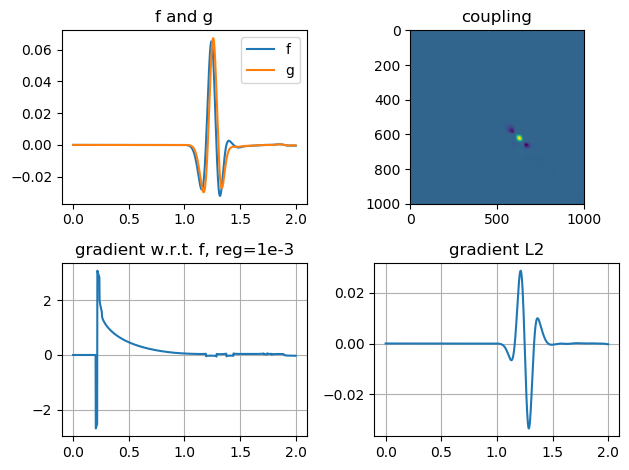

In [105]:
ind1 = 21
f = data[:,ind1]
g = data0[:,ind1]
M = cost_matrix_1d(t, t; p=2)

reg = 5e-3
reg_m = 1e4

TT,gg,dd = unbalanced_sinkhorn_1d_signal(f, g, M, reg, reg_m; iterMax=100, verbose=true)
figure;
subplot(221); plot(t,f,t,g); title("f and g"); legend(["f", "g"])
subplot(222); imshow(TT); title("coupling")
subplot(223); plot(t,gg); title("gradient w.r.t. f, reg=1e-3"); grid("on");
# ylim([-0.1,0.1])
subplot(224); plot(t,f-g); title("gradient L2"); grid("on")
tight_layout()

In [99]:
adj_source = zeros(Nt,101)
for ind = 1:101
#     f = data[:,ind]-datac[:,ind]
#     g = data0[:,ind]-datac[:,ind]
    f = data[:,ind]
    g = data0[:,ind]
    TT,adj_source[:,ind],dd = unbalanced_sinkhorn_1d_signal(f, g, M, reg, reg_m; iterMax=100, verbose=true)
end

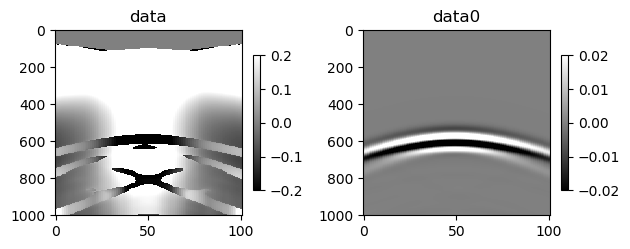

In [100]:
subplot(121)
imshow(adj_source, aspect=0.1, cmap="gray"); title("data"); colorbar(shrink=0.3); clim([-0.2,0.2])
subplot(122)
imshow(data-data0, aspect=0.1, cmap="gray"); title("data0"); colorbar(shrink=0.3); clim([-0.02,0.02])
tight_layout()

In [101]:
@time pw2 = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=10, pml_coef=100);
@time pl2 = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, data-data0, source_position, receiver_position; pml_len=10, pml_coef=100);

  8.127466 seconds (2.61 M allocations: 10.573 GiB, 17.22% gc time)
  6.507128 seconds (201.26 k allocations: 10.476 GiB, 21.26% gc time)


In [102]:
uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad_w = uu[:,:,end:-1:1,:].*pw2
grad_w = sum(grad_w, dims=[3,4])
grad_w = grad_w[:,:,1,1]

uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad_l2 = uu[:,:,end:-1:1,:].*pl2
grad_l2 = sum(grad_l2, dims=[3,4])
grad_l2 = grad_l2[:,:,1,1];

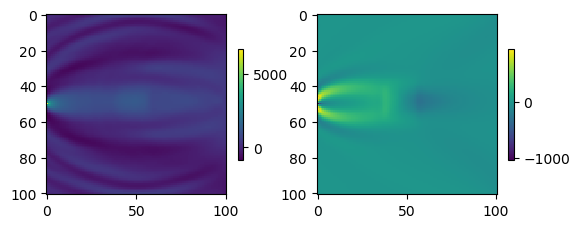

In [103]:
subplot(121)
imshow(grad_w); colorbar(shrink=0.3);
subplot(122)
imshow(grad_l2); colorbar(shrink=0.3);

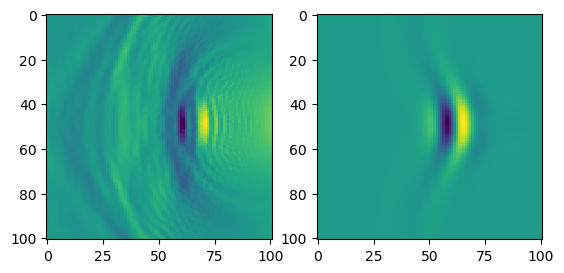

PyObject <matplotlib.image.AxesImage object at 0x142efb9d0>

In [104]:
indt = 600
subplot(121)
imshow(pw2[:,:,indt])
subplot(122)
imshow(pl2[:,:,indt])
